In [12]:
from galpy.orbit import Orbit
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.potential.mwpotentials import McMillan17
#from galpy.df import streamspraydf
from streamtools.df import streamspraydf
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

from stream_package.stream_package import graphics

In [24]:
import pickle
filehandler = open('antcra_stream.obj', 'rb') 
obj = pickle.load(filehandler)

ant_stream = obj.get("Ant no LMC")
ant_streamlmc = obj.get("Ant LMC")
ant_streamlmca = obj.get("Ant LMC acc")

In [4]:
pot1 = MWPotential2014

ro = conversion.get_physical(pot)['ro']
vo = conversion.get_physical(pot)['vo']
to = conversion.time_in_Gyr(ro=ro, vo=vo)
mo = conversion.mass_in_msol(ro=ro, vo=vo)

mass_ant = 10**7.92 #msol
scale = 1 #kpc
tdisrupt = 5

# from kinematics paper
ant2 = Orbit([143.8017, -36.6991, 131.8, -0.094, 0.103, 288.8], ro=ro, vo=vo, radec=True)
ant_unc = [0.0492, 0.08, 0, 0.007, 0.008, 0.4]
ant2.turn_physical_off()

# from pace data
ant2_ = Orbit.from_name('AntliaII', ro=ro, vo=vo)
ant2_.turn_physical_off()

In [5]:
mass_lmc=1.0e11 #solar masses
rscale_lmc=10.2 #kpc

tdisrupt=5

#Initialize and integrate the orbit of the LMC
#Note orbit has to be integrated back 5 Gyr
#Note we assume the LMC experienced dynamical friction due to MW
o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-tdisrupt/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot1, ro=ro,vo=vo)
o_lmc.integrate(ts,pot1+cdf)

#Setup a moving Hernquist potential to represent the LMC
pot1_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot1_lmc = MovingObjectPotential(o_lmc, pot1_lmc,ro=ro,vo=vo)

#Add the moving Hernquest potential to the MW
total_pot1 = [pot1]
total_pot1 += [moving_pot1_lmc]

In [6]:
>>> from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
>>> loc_origin= 1e-4 # Small offset in R to avoid numerical issues
>>> ax= lambda t: evaluateRforces(moving_pot1_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
>>> ay= lambda t: evaluatephitorques(moving_pot1_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
>>> az= lambda t: evaluatezforces(moving_pot1_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

>>> t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
>>> ax4int= np.array([ax(t) for t in t_intunits])
>>> ax_int= lambda t: np.interp(t,t_intunits,ax4int)
>>> ay4int= np.array([ay(t) for t in t_intunits])
>>> ay_int= lambda t: np.interp(t,t_intunits,ay4int)
>>> az4int= np.array([az(t) for t in t_intunits])
>>> az_int= lambda t: np.interp(t,t_intunits,az4int)

>>> from galpy.potential import NonInertialFrameForce
>>> nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

In [9]:
ant2.integrate(ts, pot1 + moving_pot1_lmc + nip)
ant2.turn_physical_on()

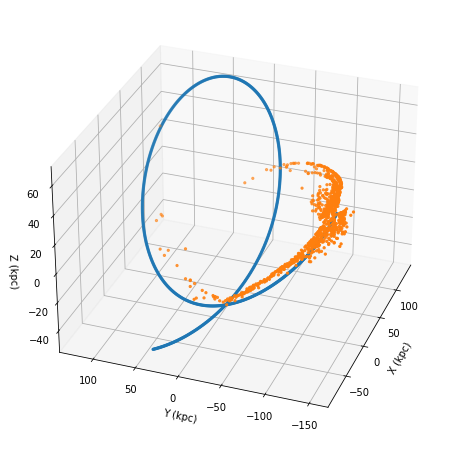

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(ant2.x(ts), ant2.y(ts), ant2.z(ts), marker='.')

ax.scatter(ant_streamlmca.x(), ant_streamlmca.y(), ant_streamlmca.z(), marker='.')
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

ax.view_init(30,200)


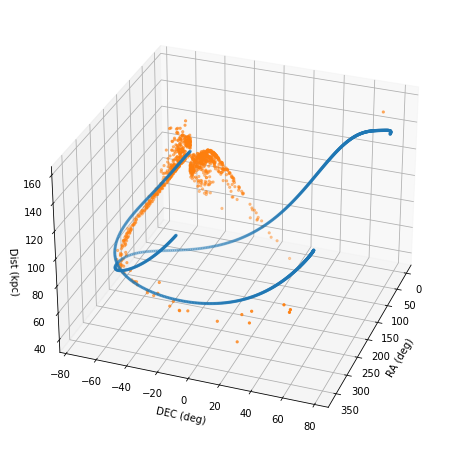

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(ant2.ra(ts), ant2.dec(ts), ant2.dist(ts), marker='.')

ax.scatter(ant_streamlmca.ra(), ant_streamlmca.dec(), ant_streamlmca.dist(), marker='.')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_zlabel('Dist (kpc)')

ax.view_init(30,20)

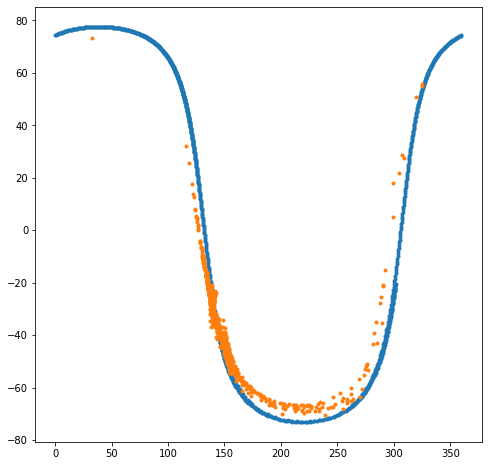

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(ant2.ra(ts), ant2.dec(ts), marker='.')
ax.scatter(ant_streamlmca.ra(), ant_streamlmca.dec(), marker='.')